In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.special import expi, betainc, beta, erf
from scipy.optimize import curve_fit
from numba import njit, jit
font = {'size': 25, 'weight':'normal'}
plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
rng = np.random.default_rng(seed=42)
colors=[['blue',"slateblue"], ['darkgoldenrod', "goldenrod"], ['red', "indianred",], ['olivedrab', "yellowgreen"], ['black','dimgray'], ['plum',"pink"],['orangered','coral'] ]

import networkx as nx
import sys
from collections import defaultdict
from numba.typed import Dict
from numba import types

In [2]:
index=3
K=index


vois=defaultdict(list)
filename = 'cl_sel1000/perc_voisins_L_1000_'+str(K)+'.dat'

Tm = np.loadtxt(filename)[:]
print(Tm)
for k in range(len(Tm)):
    Tm[k]=[int(Tm[k][i]) for i in range(2)]
for i in range(len(Tm)):
  vois[Tm[i][0]].append(Tm[i][1])
vois=dict(vois)
vois0=Dict.empty(key_type=types.int64,value_type=types.int64[:])
for i in vois.keys():
    vois0[np.int64(i)]=np.int64(np.array(vois[i]))


list_pos=np.int64(np.array(list(vois0.keys())))

edges=[]
for i in list_pos:
    for j in vois0[i]:
        if i<j:
            edges.append((i,j))

G = nx.Graph()
for i in list_pos:
    G.add_node(i)
G.add_edges_from(edges)

[[1.00000e+00 2.00000e+00]
 [1.00000e+00 3.00000e+00]
 [2.00000e+00 1.00000e+00]
 ...
 [5.04462e+05 5.04368e+05]
 [5.04463e+05 1.24700e+03]
 [5.04463e+05 5.04368e+05]]


In [3]:
Nvisits = 100000
Nsamples = 150

@jit(nopython=True)
def Starv(S,vois0):
    tau=0
    c0=list_pos[np.random.randint(len(list_pos))]
    c=c0
    pos=set()
    pos.add(c0)
    T=0
    while tau<S:
       c=vois0[c][np.random.randint(len(vois0[c]))]
       tau+=1
       T+=1
       if not (c in pos):
            pos.add(c)
            tau=0
    return len(pos),T,c0,c

@jit(nopython=True)
def flip_list_sample_2d(vois0):
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 0
    # c0=list_pos[np.random.randint(len(list_pos))]
    c0 = 1 # start in the middle of the cluster
    c=c0
    pos=set()
    pos.add(c0)

    last_color_eaten = -1 # -1 = left food (negative <=0 abscissa), 1 = right food (positive >0 abscissa)
    flip_array = []

    while food_eaten < Nvisits:
        c=vois0[c][np.random.randint(len(vois0[c]))]
        
        if not (c in pos):
            pos.add(c)
            color = 2*(c < c0) - 1 
            flip = (color * last_color_eaten)<0
            # print(c,color)
            last_color_eaten = color
            food_eaten += 1
            flip_array.append(flip)
    # print(np.sum(food_lattice))
    return np.array(flip_array)

@jit(nopython=True)
def flip_list_sample_origin(vois0):
    # here a flip happens when the RW goes from incrementing the span to the origin of the walk
    # returns an array flip_array of size Nvisits / sample_flip_gap 
    # flip[k] is 1 if there has been a flip at the sample_flip_gap * k visit, 0 else
    food_eaten = 0
    c0 = 1
    c=c0
    pos=set()
    pos.add(c0)

    last_color_eaten = -1 # -1 = origin, 1 = boundary (positive >0 abscissa)
    flip_array = np.zeros(Nvisits) # flip_array[k] is 0 if no flip at the kth visit, 1 else
    

    while food_eaten <= Nvisits:
        c=vois0[c][np.random.randint(len(vois0[c]))]
        is_c_0 = (c==c0)
        
        # only consider the event if either the walker is at the boundary, or if it transitions from the boundary to the origin
        if (not (c in pos)) or (is_c_0 and (last_color_eaten==1)):
            color = 2*(1- is_c_0) - 1 # -1 at origin, 1 else
            flip = (color * last_color_eaten)<0
            # print(c,color)
            last_color_eaten = color
            flip_array[food_eaten] = flip
            if not (is_c_0):
                  pos.add(c)
                  # only add food when visiting a new site !! not when going to the origin.
                  food_eaten += 1
                  
    return flip_array

In [4]:
f = []
for s in range(Nsamples):
    f.append(flip_list_sample_origin(vois0))
    print(s)
    # print(np.sum(np.array(f)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [5]:
f_mean = np.mean(f, axis=0)
mean_F = np.cumsum(f_mean)
np.save("./mean_F_percolation.npy",mean_F)

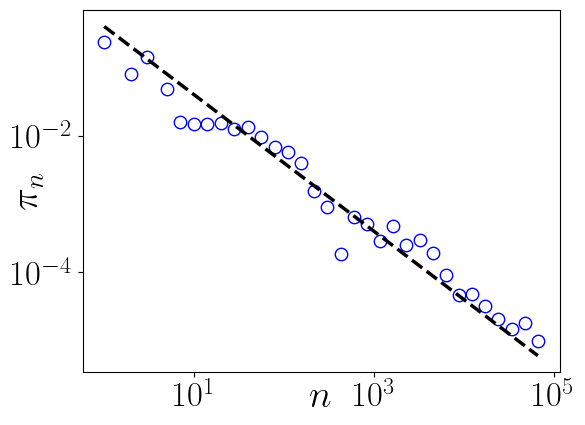

In [3]:
mean_F = np.load("./mean_F_percolation.npy")
Nvisits=mean_F.size
base=1.4
t_logscale = np.array([int(base**i) for i in range(0,int(np.emath.logn(base,Nvisits)))])
pi_coarsegrained = np.array([(mean_F[int(base**(i+1))]-mean_F[int(base**i)])/(int(base**(i))) for i in range(0,int(np.emath.logn(base,Nvisits)))])
fig, ax = plt.subplots(1, 1)
plt.scatter(
    t_logscale,
    pi_coarsegrained,
    color='blue',           # Edge color
    s=80,                    # Marker size (7^2)
    facecolors='white',      # Hollow markers
    linewidths=1             # Edge line width
)

plt.plot(t_logscale, .4/ (t_logscale),'--k',linewidth=2.5)
# plt.plot(t_logscale, 0.1/ (t_logscale),'--',color='red')
plt.semilogx()
plt.semilogy()

ax.set_ylabel(r'$\pi_n$', fontsize=28, labelpad=-25,loc='center')
ax.set_xlabel(r'$n$', fontsize=28, labelpad=-25,loc='center')
plt.tight_layout()
plt.savefig('./Figures/pin-percolation.pdf', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_19640\1829663061.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(times,mean_F / np.log(times) )
C:\Users\julie\AppData\Local\Temp\ipykernel_19640\1829663061.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times,mean_F / np.log(times) )
C:\Users\julie\AppData\Local\Temp\ipykernel_19640\1829663061.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(times, np.ones(times.size)*(mean_F / (np.log(times)))[-1],'--k')
C:\Users\julie\AppData\Local\Temp\ipykernel_19640\1829663061.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, np.ones(times.size)*(mean_F / (np.log(times)))[-1],'--k')


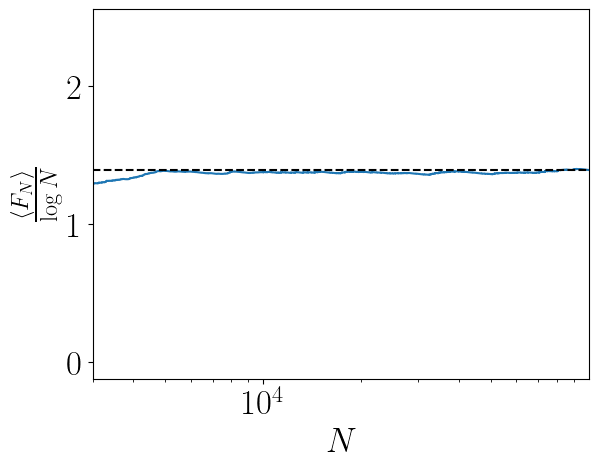

: 

In [ ]:
mean_F = np.mean(np.cumsum(f,axis=1),axis=0  )
times = np.arange(Nvisits)

fig, ax = plt.subplots(1,1)

plt.plot(times,mean_F / np.log(times) )
plt.plot(times, np.ones(times.size)*(mean_F / (np.log(times)))[-1],'--k')
# plt.plot(times, sqrtfit(times,A))
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\frac{\langle F_N \rangle}{\log N}$")
plt.semilogx()
plt.xlim(3000,times[-1])
# plt.xlim(-2.5,4)
plt.savefig(f"Figures/mean-nb-flips-percolation-boundary-to-origin.pdf", dpi=600,bbox_inches='tight')
plt.show()